# irt

> Some basic tooling in item response theory for analyzing the results of ML benchmarks

In [7]:
#| default_exp irt

In the following we will use item response theory (IRT) to analyze benchmark results. 

A common model in IRT is the Rasch model, which described the probability of a correct response ($P(X=1)$) as a function of the ability of the person ($\theta_n$) and the difficulty ($\beta_i$) of the item: 

$$
P(X_{ni} =1| \theta_n, \beta_i) = \frac{\exp\{\theta_n - \beta_i\}}{1 + \exp\{\theta_n - \beta_i\}}
$$

We can make this more general by adding a discrimination parameter $\alpha_i$: This parameter describes how well the item discriminates between models of different abilities. The probability of a correct response is then given by:

$$
P(X_{ni} =1| \theta_n, \beta_i, \alpha_i) = \frac{\exp\{\alpha_i(\theta_n - \beta_i)\}}{1 + \exp\{\alpha_i(\theta_n - \beta_i)\}}
$$

This is the 2PL model.

In [8]:
#| hide
from nbdev.showdoc import *

In [9]:
# | hide
import pandas as pd 
import pickle

In [10]:
# | export
import numpy as np 
from girth import twopl_mml, rasch_mml, ability_mle

In [211]:
with open('../data/filtered_model_score_dict.pkl', 'rb') as f:
    model_score_dicts = pickle.load(f)

In [105]:
model_score_dicts['overall'].keys()

dict_keys(['Mistral-Large-2', 'Llama-3.1-70B-Instruct', 'Claude-3.5 (Sonnet)', 'Mistral-8x7b-Instruct', 'Command-R+', 'Llama-3.1-405B-Instruct', 'Llama-3.1-8B-Instruct', 'GPT-4o', 'Llama-3-70B-Instruct', 'PaperQA2', 'Gemma-1.1-7B-it', 'Gemma-2-9B-it', 'Llama-2-70B Chat', 'Galatica-120b', 'Llama-3-8B-Instruct', 'Gemini-Pro', 'o1', 'GPT-4', 'Phi-3-Medium-4k-Instruct', 'Claude-3 (Opus)', 'GPT-3.5 Turbo Zero-T', 'Claude-2-Zero-T'])

In [232]:
model_score_dicts['overall']['Claude-3.5 (Sonnet)']

{'canary_0': 0       BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...
 2       BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...
 3       BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...
 4       BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...
 5       BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...
                               ...                        
 2840    BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...
 2845    BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...
 2848    BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...
 2849    BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...
 2850    BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...
 Name: canary_0, Length: 1116, dtype: object,
 'description_0': 0                                          ghs pictograms
 2                      Chemical mixing compatibility test
 3       Diazonium Salts characteristics questions, inc...
 4       Amines, Aromatic characteristics questions, in...
 5       Questions from the questions ba

In [110]:
models = list(model_score_dicts['overall'].keys())

# Print sizes to debug
print(f"Number of models: {len(models)}")
print(f"Size of Claude's all_correct: {len(model_score_dicts['overall']['Claude-3.5 (Sonnet)']['all_correct_'])}")
for model in models:
    print(f"{model}: {len(model_score_dicts['overall'][model]['all_correct_'])}")

# Create matrix with correct dimensions
binary_matrix = np.zeros((len(model_score_dicts['overall']['Claude-3.5 (Sonnet)']['all_correct_']), len(models)))

for i, model in enumerate(models):
    binary_matrix[:,i] = model_score_dicts['overall'][model]['all_correct_'].values

# Convert to DataFrame
binary_df = pd.DataFrame(binary_matrix, columns=models)
print("\nFinal DataFrame size:", len(binary_df))

Number of models: 22
Size of Claude's all_correct: 1116
Mistral-Large-2: 1116
Llama-3.1-70B-Instruct: 1116
Claude-3.5 (Sonnet): 1116
Mistral-8x7b-Instruct: 1116
Command-R+: 1116
Llama-3.1-405B-Instruct: 1116
Llama-3.1-8B-Instruct: 1116
GPT-4o: 1116
Llama-3-70B-Instruct: 1116
PaperQA2: 1116
Gemma-1.1-7B-it: 1116
Gemma-2-9B-it: 1116
Llama-2-70B Chat: 1116
Galatica-120b: 1116
Llama-3-8B-Instruct: 1116
Gemini-Pro: 1116
o1: 1116
GPT-4: 1116
Phi-3-Medium-4k-Instruct: 1116
Claude-3 (Opus): 1116
GPT-3.5 Turbo Zero-T: 1116
Claude-2-Zero-T: 1116

Final DataFrame size: 1116


In [111]:
models = list(model_score_dicts['overall'].keys())
binary_matrix = np.zeros((len(model_score_dicts['overall']['Claude-3.5 (Sonnet)']['all_correct_']), len(models)))

for i, model in enumerate(models):
   binary_matrix[:,i] = model_score_dicts['overall'][model]['all_correct_'].values

# Convert to pandas DataFrame for better visualization
binary_df = pd.DataFrame(binary_matrix, columns=models)
print(len(binary_df))

1116


In [112]:
# create array from dataframe
binary_array = binary_df.to_numpy()


In [113]:
# i want a binary matrix  rows are score for questions and columns are models
#model_score_dicts['overall'].keys() gives model name
# model_score_dicts['overall']['Claude-3.5 (Sonnet)']['all_correct_'] gives the score for the model



In [114]:
# | export
from enum import Enum
from dataclasses import dataclass
from typing import Dict

In [115]:
# | export
class ScoringType(Enum): 
    BINARY = 'binary'
    PARTIAL = 'partial'

We define a container to store meta information for each question (item). We will track some identifier and what type of scoring the question uses.

In [116]:
# | export

@dataclass
class QuestionMetadata:
    """Base class for question metadata"""
    question_id: str
    scoring_type: ScoringType

    def compute_score(self, response) -> float:
        """Base method for computing scores"""
        raise NotImplementedError
    



In [117]:
# | export

@dataclass
class BinaryQuestionMetadata(QuestionMetadata):
    """Metadata for binary scored questions"""
    def __init__(self, question_id: str):
        super().__init__(question_id, ScoringType.BINARY)

    def compute_score(self, row, column: str='all_correct_') -> float:
        """Use the all_correct column directly"""
        return float(row[column])

In [118]:
# | export

class BenchmarkAnalyzer:
    def __init__(self):
        self.model_dataframes: Dict[str, pd.DataFrame] = {}
        self.question_metadata: Dict[str, QuestionMetadata] = {}
        self.score_matrix = None
        self.model_ids = None

    def add_model_results(self, model_id: str, results_df: pd.DataFrame):
        """Add a model's results DataFrame"""
        self.model_dataframes[model_id] = results_df

    def add_question_metadata(self, metadata: QuestionMetadata):
        """Add metadata for a question"""
        self.question_metadata[metadata.question_id] = metadata

    def compute_score_matrix(self) -> np.ndarray:
        """Compute score matrix using metadata-specific scoring"""
        if not self.model_dataframes or not self.question_metadata:
            raise ValueError("Need both model results and question metadata")

        self.model_ids = list(self.model_dataframes.keys())
        question_ids = list(self.question_metadata.keys())

        # Initialize score matrix
        self.score_matrix = np.full(
            (len(self.model_ids), len(question_ids)), 
            np.nan
        )

        # Compute scores
        for model_idx, model_id in enumerate(self.model_ids):
            df = self.model_dataframes[model_id]
            for q_idx, q_id in enumerate(question_ids):
                if q_id not in df.index:
                    continue

                metadata = self.question_metadata[q_id]
                row = df.loc[q_id]

                self.score_matrix[model_idx, q_idx] = metadata.compute_score(row)


        return self.score_matrix

    def fit_irt(self, model='2pl') -> Dict[str, pd.DataFrame]:
        if self.score_matrix is None:
            self.compute_score_matrix()

        binary_matrix = (self.score_matrix >= 0.5).astype(int).T #  needs to be [n_items, n_participants]
        
        if model == '2pl':
            # options = {
            # 'max_iteration': 200,
            # 'quadrature_n': 61,  # More quadrature points for better precision
            # 'quadrature_bounds': (-6, 6),  # Default bounds
            # 'estimate_distribution': True  # Allow distribution estimation
            # }

            results = twopl_mml(binary_matrix)
            difficulties = results['Difficulty']
            discriminations = results['Discrimination']
        else:  # rasch
            results = rasch_mml(binary_matrix)
            difficulties = results['Difficulty']
            discriminations = np.ones_like(difficulties) 
        
        abilities = ability_mle(
            binary_matrix,  
            difficulties,
            discriminations,
            no_estimate=np.nan  
        )

        return {
            'difficulties': difficulties,
            'discriminations': discriminations,
            'abilities': abilities, 
            'binary_matrix': binary_matrix
        }


    def analyze_extreme_items(difficulties, discriminations, question_ids, threshold=0.95):
        """Identify items with extreme parameters"""
        extreme_items = pd.DataFrame({
            'question_id': question_ids,
            'difficulty': difficulties,
            'discrimination': discriminations
        })

        # Find items with extreme values
        extreme_items['is_extreme'] = (
            (discriminations > threshold * 5.0) |  # High discrimination
            (difficulties > threshold * 6.0) |     # Very difficult
            (difficulties < -4.0)                  # Very easy
        )

        return extreme_items[extreme_items['is_extreme']]



Now, let's the class with some of our data

In [119]:
analyzer = BenchmarkAnalyzer()

for model_id, df in model_score_dicts['overall'].items():
    analyzer.add_model_results(model_id, df)


# for now, let's just add the binary questions

for i, row in model_score_dicts['overall']['Claude-2-Zero-T'].iterrows():
    if row['metrics_hamming']:
        analyzer.add_question_metadata(BinaryQuestionMetadata(i))


AttributeError: 'dict' object has no attribute 'iterrows'

In [120]:
len(analyzer.question_metadata)

0

In [121]:
results = analyzer.fit_irt(model='rasch')

ValueError: Need both model results and question metadata

In [122]:
results['abilities']

array([ 0.92062274,  0.70085661,  0.43172056, -0.33257593,  0.18210808,
        0.97653286,  0.26776643,  0.95411399,  0.46383346,  0.73349057,
       -1.47287807,  0.30697452, -1.099009  , -4.0792575 ,  0.28559071,
        0.27133169,  1.18214098, -0.5245331 ,  0.32122829, -0.2613409 ,
        0.20711413, -3.02995173])

In [123]:
# print how many zeros in matrix
print(results['binary_matrix'].shape )

(1614, 22)


In [124]:
dict(zip(analyzer.model_ids, results['abilities']))

TypeError: 'NoneType' object is not iterable

This seems to be quite different from a naive ranking based on taking the mean of the scores.
Let's perform some more detailed analysis what causes the differences.

In [125]:
def analyze_influential_questions(binary_matrix, abilities, difficulties, discriminations, model_ids, question_ids):
    """Analyze which questions cause the biggest differences between IRT and average scoring"""

    # Get both scoring methods
    avg_scores = np.mean(binary_matrix.T, axis=1)
    print(avg_scores.shape)

    # Create base comparison DataFrame
    model_comparison = pd.DataFrame({
        'model_id': model_ids,
        'irt_ability': abilities,
        'avg_score': avg_scores,
        'irt_rank': pd.Series(abilities).rank(ascending=False),
        'avg_rank': pd.Series(avg_scores).rank(ascending=False)
    }).set_index('model_id')
    print(model_comparison)

    # Find models with large ranking differences
    model_comparison['rank_diff'] = model_comparison['avg_rank'] - model_comparison['irt_rank']
    interesting_models = model_comparison[abs(model_comparison['rank_diff']) > 2]

    # Analyze question characteristics for these models
    question_analysis = pd.DataFrame({
        'question_id': question_ids,
        'difficulty': difficulties,
        'discrimination': discriminations,
        'avg_success_rate': np.mean(binary_matrix.T, axis=0)
    })

    # For each interesting model, analyze its response pattern
    for model_id in interesting_models.index:
        model_idx = model_ids.index(model_id)
        responses = binary_matrix[model_idx]

        # Calculate contribution to IRT score
        # Higher contribution when succeeding on difficult/discriminating items
        question_analysis[f'{model_id}_contribution'] = (
            responses * discriminations * (difficulties - abilities[model_idx])
        )

        # Add raw response
        question_analysis[f'{model_id}_response'] = responses

    # Find most influential questions
    influential_questions = question_analysis[
        (question_analysis['discrimination'] > np.percentile(discriminations, 75)) |
        (abs(question_analysis['difficulty']) > 2)
    ]

    return {
        'model_differences': interesting_models,
        'influential_questions': influential_questions.sort_values('discrimination', ascending=False)
    }

# Example usage:
influential_analysis_results = analyze_influential_questions(
    results['binary_matrix'],
    results['abilities'], 
    results['difficulties'], 
    results['discriminations'], 
    analyzer.model_ids, 
    list(analyzer.question_metadata.keys())
)

print("\nModels with largest ranking differences:")
print(influential_analysis_results['model_differences'])


(22,)
          irt_ability  avg_score  irt_rank  avg_rank
model_id                                            
None         0.920623   0.545849       4.0       4.0
None         0.700857   0.508674       6.0       6.0
None         0.431721   0.462206       8.0       8.0
None        -0.332576   0.331475      17.0      17.0
None         0.182108   0.418835      15.0      15.0
None         0.976533   0.555143       2.0       2.0
None         0.267766   0.433705      13.0      13.0
None         0.954114   0.551425       3.0       3.0
None         0.463833   0.467782       7.0       7.0
None         0.733491   0.514250       5.0       5.0
None        -1.472878   0.169765      20.0      20.0
None         0.306975   0.440520      10.0      10.0
None        -1.099009   0.216233      19.0      19.0
None        -4.079258   0.019827      22.0      22.0
None         0.285591   0.436803      11.0      11.0
None         0.271332   0.434325      12.0      12.0
None         1.182141   0.588600       1

ValueError: All arrays must be of the same length

In [126]:

print("\nMost influential questions:")
print(influential_analysis_results['influential_questions'].head(10))


Most influential questions:
     question_id  difficulty  discrimination  avg_success_rate
0              0    2.173210             1.0          0.136364
821         1450    2.173210             1.0          0.136364
892         1585    5.999939             1.0          0.000000
884         1566    2.679903             1.0          0.090909
862         1527   -3.477644             1.0          0.954545
849         1498    2.173210             1.0          0.136364
848         1497    2.173210             1.0          0.136364
835         1471    3.477478             1.0          0.045455
828         1462    5.999939             1.0          0.000000
824         1454    2.173210             1.0          0.136364


In [127]:
model_score_dicts['overall']['GPT-4'].iloc[1879]

AttributeError: 'dict' object has no attribute 'iloc'

In [128]:
#| hide
import nbdev; nbdev.nbdev_export()

<Axes: >

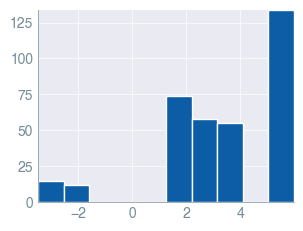

In [129]:
influential_analysis_results['influential_questions']['difficulty'].hist()

In [130]:
influential_analysis_results['influential_questions'][influential_analysis_results['influential_questions']['difficulty']<0]

,question_id,difficulty,discrimination,avg_success_rate
862,1527,-3.477644,1.0,0.954545
894,1590,-2.173275,1.0,0.863636
898,1595,-2.173275,1.0,0.863636
998,1778,-2.173275,1.0,0.863636
996,1775,-2.679993,1.0,0.909091
899,1596,-2.173275,1.0,0.863636
563,977,-2.173275,1.0,0.863636
544,946,-2.173275,1.0,0.863636
1448,2563,-3.477644,1.0,0.954545
1349,2386,-2.679993,1.0,0.909091


In [131]:
model_score_dicts['overall']['GPT-4'].iloc[1590]['prompt_0']

AttributeError: 'dict' object has no attribute 'iloc'

Let's see if we can make it Bayesian with `pymc`

In [132]:
import pymc as pm
import numpy as np
import arviz as az


def fit_2pl_pymc(response_matrix, n_samples=2000, tune=2000): 
    n_participants, n_items = response_matrix.shape
    with pm.Model() as irt_2pl:
        
        # 1. Standardize input data if not already done         
        # response_matrix = (response_matrix - np.mean(response_matrix)) / np.std(response_matrix)          
        # 2. Abilities with stronger regularization
        abilities = pm.Normal('abilities',
                              mu=0,                              
                              sigma=0.5,  # Tighter prior
                              shape=n_participants)
        # 3. Simpler discrimination parameterization         
        # Constrain to reasonable range [0.5, 2.5]
        discriminations = pm.TruncatedNormal('discriminations',
                                             mu=1.0,
                                             sigma=0.3,
                                             lower=0.5,
                                             upper=2.5,                                            shape=n_items)
        
        # 4. Difficulties with tighter bounds
        difficulties = pm.TruncatedNormal('difficulties',
                                        mu=0,
                                        sigma=0.5,
                                        lower=-2,
                                        upper=2,
                                        shape=n_items)

        # 5. More stable computation with scaling
        scaled_abilities = abilities[:, None] / 2.0  # Scale down
        scaled_difficulties = difficulties[None, :] / 2.0
        scaled_disc = discriminations[None, :] / 2.0

        # Compute logit with scaled parameters
        logit_p = scaled_disc * (scaled_abilities - scaled_difficulties)

        # 6. Likelihood
        responses = pm.Bernoulli('responses',
                                logit_p=logit_p,
                                observed=response_matrix)

        # 7. Improved sampling settings
        trace = pm.sample(n_samples,
                         tune=tune,
                         chains=4,
                         target_accept=0.99,
                         init='jitter+adapt_diag',  # Different initializer
                         return_inferencedata=True,
                         cores=1)  # Single core for better stability

    return trace

# Modern diagnostics using ArviZ
def check_model_diagnostics(trace):
    """Comprehensive model diagnostics"""
    diagnostics = {
        'r_hat': az.rhat(trace),
        'ess': az.ess(trace),
        'mcse': az.mcse(trace),
        'divergences': az.summary(trace)['diverging'].sum()
    }

    # Check for convergence issues
    has_issues = (
        (diagnostics['r_hat'] > 1.01).any() or
        (diagnostics['ess'] < 400).any() or
        diagnostics['divergences'] > 0
    )

    if has_issues:
        print("Warning: Potential convergence issues detected")

    return diagnostics


In [133]:
with pm.Model() as model:
    trace_all_correct = fit_2pl_pymc(binary_array.T)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [abilities, discriminations, difficulties]


Output()

Output()

Output()

Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1052 seconds.


In [134]:
# save trace as pickle file
with open('../data/trace_all_correct_filtered.pkl', 'wb') as f:
    pickle.dump(trace_all_correct, f)

In [171]:
# open already computed scores
with open('../data/trace_all_correct_filtered.pkl', 'rb') as f:
    trace_all_correct = pickle.load(f)

In [135]:
difficulty_vector = trace_all_correct.posterior['difficulties'].mean(dim=['chain', 'draw']).values

In [136]:
# load json file
import json
with open('../data/difficulty_dict.json', 'r') as f:
    difficulty_dict = json.load(f)

In [137]:
difficulty_vector_dataframe = pd.DataFrame(difficulty_vector, columns=['difficulty'])

In [138]:
difficulty_vector_dataframe

,difficulty
0,0.444984
1,0.653472
2,-0.630740
3,-0.572958
4,0.316071
...,...
1111,0.013804
1112,0.183771
1113,0.134585
1114,-0.436721


In [139]:
difficulty_vector_dataframe

#extend the difficulty dataframe with one more column based on the index. Use the difficulty_dict to assign values to the new column. all index that are easy is 0, intermediate is 1 and hard is 2

difficulty_vector_dataframe['difficulty_level'] = difficulty_vector_dataframe.index.map(difficulty_dict)

In [140]:
# Create mapping dictionary with default value 
level_map = {i: 2 for i in range(len(difficulty_vector))}  # Default to 'hard' (2)

# Map easy indices to 0
for i in difficulty_dict['easy']:
   level_map[i] = 0
   
# Map intermediate indices to 1
for i in difficulty_dict['intermediate']: 
   level_map[i] = 1

# Add new column
difficulty_vector_dataframe['difficulty_level'] = difficulty_vector_dataframe.index.map(level_map)

In [141]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.constants import golden

plt.style.use("lamalab.mplstyle")

ONE_COL_WIDTH_INCH = 3.25
TWO_COL_WIDTH_INCH = 7.2
ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
TWO_COL_GOLDEN_RATIO_HEIGHT_INCH = TWO_COL_WIDTH_INCH / golden

def range_frame(ax, x, y, pad=0.1):
    y_min, y_max = np.min(y), np.max(y)
    x_min, x_max = np.min(x), np.max(x)
    
    ax.set_ylim(y_min - pad * (y_max - y_min), 
                y_max + pad * (y_max - y_min))
    # ax.set_xlim(x_min * (1 - pad), 
    #             x_max * (1 + pad))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.spines['left'].set_bounds(y_min, y_max)
    ax.spines['bottom'].set_bounds(x_min, x_max)

def plot_difficulty_violin(df):
   plt.figure(figsize=(ONE_COL_WIDTH_INCH, 1.2 *ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
   
   # Create violin plot
   ax = sns.violinplot(data=df, x='difficulty_level', y='difficulty', color="#FFBA08",linewidth=0.75)
   
   # Apply range frame
   x = df['difficulty_level'].unique()
   y = df['difficulty'].values
   range_frame(ax, x, y)
   
   # Customize labels
   ax.set_xticklabels(['Easy', 'Intermediate', 'Hard'])

#    plt.title('Difficulty Distribution')
   plt.xlabel('Human Assigned')
   plt.ylabel('Computed Difficulty')
   
   plt.tight_layout()
   plt.savefig("difficulty.pdf", format='pdf')

   plt.show()

In [142]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.constants import golden

plt.style.use("lamalab.mplstyle")

ONE_COL_WIDTH_INCH = 3.25
TWO_COL_WIDTH_INCH = 7.2
ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
TWO_COL_GOLDEN_RATIO_HEIGHT_INCH = TWO_COL_WIDTH_INCH / golden

def range_frame(ax, x, y, pad=0.1):
    y_min, y_max = np.min(y), np.max(y)
    x_min, x_max = np.min(x), np.max(x)
    
    ax.set_ylim(y_min - pad * (y_max - y_min), 
                y_max + pad * (y_max - y_min))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.spines['left'].set_bounds(y_min, y_max)
    ax.spines['bottom'].set_bounds(x_min, x_max)

def plot_difficulty_swarm(df):
    plt.figure(figsize=(TWO_COL_WIDTH_INCH, TWO_COL_WIDTH_INCH/2), facecolor='white')
    
    # Create swarm plot with much smaller points
    ax = sns.swarmplot(data=df, x='difficulty_level', y='difficulty', color="#6A040F", size=1)
    
    # Apply range frame
    x = df['difficulty_level'].unique()
    y = df['difficulty'].values
    range_frame(ax, x, y)
    
    # Customize labels
    ax.set_xticklabels(['Easy', 'Intermediate', 'Hard'])
    
    plt.xlabel('Human Assigned')
    plt.ylabel('Computed Difficulty')
    ax.set_facecolor('white')
    
    plt.tight_layout()
    plt.savefig("difficulty.pdf", format='pdf')
    
    plt.show()

/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_6276/2177926585.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Easy', 'Intermediate', 'Hard'])


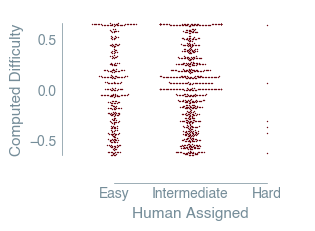

In [155]:
plot_difficulty_swarm(difficulty_vector_dataframe)

/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_6276/1313478027.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Easy', 'Intermediate', 'Hard'])


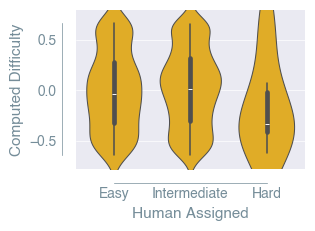

In [146]:
plot_difficulty_violin(difficulty_vector_dataframe)

In [147]:
abilities_mean = trace_all_correct.posterior['abilities'].mean(dim=['chain', 'draw']).values

In [148]:
len(abilities_mean)

22

In [149]:
sum(model_score_dicts['overall']['Mistral-Large-2']['all_correct_'])/len(model_score_dicts['overall']['Mistral-Large-2']['all_correct_'])

0.5627240143369175

In [183]:
# Get point estimates and uncertainty
def get_parameter_estimates(trace):
    estimates = {
        'abilities': {
            'mean': trace.posterior['abilities'].mean(dim=['chain', 'draw']).values,
            'std': trace.posterior['abilities'].std(dim=['chain', 'draw']).values,
            'hdi': az.hdi(trace, var_names=['abilities'])
        },
        'discriminations': {
            'mean': trace.posterior['discriminations'].mean(dim=['chain', 'draw']).values,
            'std': trace.posterior['discriminations'].std(dim=['chain', 'draw']).values,
            'hdi': az.hdi(trace, var_names=['discriminations'])
        },
        'difficulties': {
            'mean': trace.posterior['difficulties'].mean(dim=['chain', 'draw']).values,
            'std': trace.posterior['difficulties'].std(dim=['chain', 'draw']).values,
            'hdi': az.hdi(trace, var_names=['difficulties'])
        }
    }
    return estimates


In [150]:
model_list = list(model_score_dicts['overall'].keys())

model_score_list = []
for model in model_list:
    #print(sum(model_score_dicts['overall'][model]['all_correct_'])/len(model_score_dicts['overall'][model]['all_correct_']))
    model_score_list.append(sum(model_score_dicts['overall'][model]['all_correct_'])/len(model_score_dicts['overall'][model]['all_correct_']))

model_score_df = pd.DataFrame(model_score_list, index=model_list, columns=['score'])

In [259]:
def plot_model_comparison2(df, abilities_mean, abilities_std=None, models_to_plot=None, colors=None):
    fig, ax = plt.subplots(figsize=(1.5*ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
    
    # Normalize both the average scores and abilities to 0-1 scale
    df_norm = (df - df.min()) / (df.max() - df.min())
    abilities_norm = (abilities_mean - abilities_mean.min()) / (abilities_mean.max() - abilities_mean.min())
    
    # Normalize the standard deviations using the same scale factor as abilities
    scale_factor = 1 / (abilities_mean.max() - abilities_mean.min())
    abilities_std_norm = abilities_std * scale_factor
    
    if models_to_plot is None:
        models_to_plot = df.index
        
    if colors is None:
        colors = ['#03071E', '#3A3B73', '#6A040F', '#B20404', '#D63909', '#E27F07', '#F9BB0B', '#FFDA00']

    x = np.array([0.1, 0.9])
    
    for i, model in enumerate(models_to_plot):
        idx = df.index.get_loc(model)
        y = np.array([df_norm.loc[model, 'score'], abilities_norm[idx]])
        
        # Bestimme das Label für die Legende
        if model == 'o1':
            label = 'o1-preview'
        elif model == 'Claude-2-Zero-T':
            label = 'Claude-2'
        elif model == 'GPT-3.5 Turbo Zero-T':
            label = 'GPT-3.5 Turbo'
        else:
            label = model
        
        # Plot the line with updated label
        plt.plot(x, y, '-', label=label, color=colors[i % len(colors)], linewidth=1.5)
        
        # Add error bar for IRT score without caps (capsize=0)
        plt.errorbar(0.9, abilities_norm[idx], yerr=abilities_std_norm[idx], 
                    fmt='none', color=colors[i % len(colors)], capsize=0, linewidth=1)

    plt.xticks([0.1, 0.9], ['Current\nimplementation', 'IRT'])
    plt.ylabel('Normalized Score')
    
    # Set axis limits
    ymin = min(0, np.min(abilities_norm - abilities_std_norm) - 0.05)
    ymax = max(1, np.max(abilities_norm + abilities_std_norm) + 0.05)
    plt.ylim(ymin, ymax)
    plt.xlim(0, 1)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    range_frame(ax, x, np.concatenate([df_norm.loc[models_to_plot, 'score'],
                                   abilities_norm[[df.index.get_loc(m) for m in models_to_plot]]]))
    ax.set_facecolor('white')
    
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig("model_comparison.pdf", format='pdf')
    plt.show()

[ 0.72772309 -0.16587325  1.69174719 -1.70986738 -1.06267171  1.12509361
 -0.76873453  1.31927539 -0.0236423   0.72035373 -2.70362941 -0.66138862
 -5.0999522  -7.58134431 -0.80547254 -0.708606    2.05468803  0.48900588
 -0.65194003  0.5133233  -0.73844795 -0.58723817]


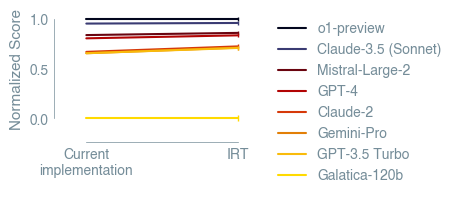

In [260]:
models_to_plot = ['o1', 'Claude-3.5 (Sonnet)', 'Mistral-Large-2', 'GPT-4', 'Claude-2-Zero-T', 'Gemini-Pro',
                 'GPT-3.5 Turbo Zero-T', 'Galatica-120b']

# Get the estimates first
estimates = get_parameter_estimates(trace_all_correct)
abilities_mean = estimates['abilities']['mean']
abilities_std = estimates['abilities']['std']

print(abilities_mean)

# plot model comparison with error bars
plot_model_comparison2(model_score_df, abilities_mean, abilities_std, models_to_plot)

[ 0.72772309 -0.16587325  1.69174719 -1.70986738 -1.06267171  1.12509361
 -0.76873453  1.31927539 -0.0236423   0.72035373 -2.70362941 -0.66138862
 -5.0999522  -7.58134431 -0.80547254 -0.708606    2.05468803  0.48900588
 -0.65194003  0.5133233  -0.73844795 -0.58723817]
Standard Deviations for each model:
o1: 0.2062
Claude-3.5 (Sonnet): 0.2053
Mistral-Large-2: 0.2009
GPT-4: 0.2011
Claude-2-Zero-T: 0.2010
Gemini-Pro: 0.2048
GPT-3.5 Turbo Zero-T: 0.2054
Galatica-120b: 0.2886


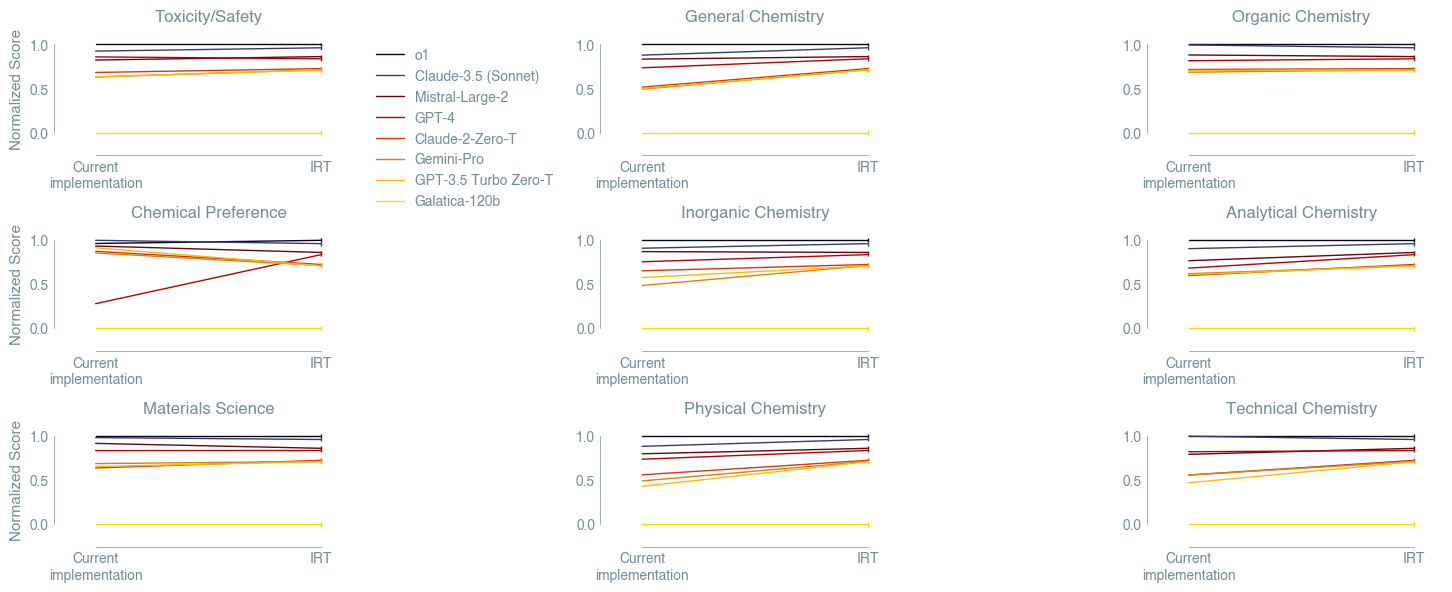

In [208]:
def plot_model_comparison_by_topic(df, abilities_mean, abilities_std, topics, models_to_plot=None, colors=None):
   print(abilities_mean)
   
   # Create figure with subplots for each topic
   n_topics = len(topics)
   n_cols = 3
   n_rows = (n_topics + 2) // 3
   print("Standard Deviations for each model:")
   for i, model in enumerate(models_to_plot):
        idx = df.index.get_loc(model)
        print(f"{model}: {abilities_std[idx]:.4f}")
       
    
   
   fig, axes = plt.subplots(n_rows, n_cols, 
                           figsize=(4.5*ONE_COL_WIDTH_INCH, n_rows*ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
   axes = axes.flatten()
   
   if models_to_plot is None:
       models_to_plot = df.index
       
   if colors is None:
       colors = ['#03071E', '#3A3B73', '#6A040F', '#B20404', '#D63909', '#E27F07', '#F9BB0B', '#FFDA00']
   
   # Create subplot for each topic
   for topic_idx, topic in enumerate(topics):
       ax = axes[topic_idx]
       
       # Extract topic-specific data
       topic_scores = []
       for model in models_to_plot:
           topic_data = model_score_dicts['overall'][model]
           topic_mask = topic_data['topic'] == topic
           correct_answers = topic_data['all_correct_'][topic_mask]
           topic_score = correct_answers.mean()
           topic_scores.append(topic_score)
           
       topic_df = pd.DataFrame(topic_scores, index=models_to_plot, columns=['score'])
       
       # Normalize scores
       df_norm = (topic_df - topic_df.min()) / (topic_df.max() - topic_df.min())
       abilities_norm = (abilities_mean - abilities_mean.min()) / (abilities_mean.max() - abilities_mean.min())
       
       # Normalize standard deviations
       scale_factor = 1 / (abilities_mean.max() - abilities_mean.min())
       abilities_std_norm = abilities_std * scale_factor
       
       x = np.array([0.1, 0.9])
       y_values = []  # Collect all y-values for axis limits
       
       for i, model in enumerate(models_to_plot):
           idx = df.index.get_loc(model)
           y = np.array([df_norm.loc[model, 'score'], abilities_norm[idx]])
           y_values.extend([y[0], y[1]])
           
           ax.plot(x, y, '-', label=model, color=colors[i % len(colors)], linewidth=1.0)
           
           y_err = abilities_std_norm[idx]
           y_values.extend([abilities_norm[idx] - y_err, abilities_norm[idx] + y_err])
           ax.errorbar(0.9, abilities_norm[idx], yerr=y_err, 
                      fmt='none', color=colors[i % len(colors)], capsize=0,
                      linewidth=1)
       
       ax.set_xticks([0.1, 0.9])
       ax.set_xticklabels(['Current\nimplementation', 'IRT'])
       if topic_idx % n_cols == 0:
           ax.set_ylabel('Normalized Score')
       
       # Set axis limits with padding
       ymin = min(y_values) - 0.05
       ymax = max(y_values) + 0.05
       ax.set_ylim(ymin, ymax)
       ax.set_xlim(0, 1)
       
       ax.set_title(topic, pad=10)
       ax.set_facecolor('white')
       
       if topic_idx == 0:
           ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
       
       range_frame(ax, x, np.concatenate([df_norm.loc[models_to_plot, 'score'],
                                        abilities_norm[[df.index.get_loc(m) for m in models_to_plot]]]))
   
   # Remove empty subplots
   for idx in range(topic_idx + 1, len(axes)):
       fig.delaxes(axes[idx])
   
   fig.patch.set_facecolor('white')
   plt.tight_layout()
   plt.savefig("model_comparison_by_topic.pdf", format='pdf', bbox_inches='tight')
   plt.show()


sample_model = list(model_score_dicts['overall'].keys())[0]
unique_topics = model_score_dicts['overall'][sample_model]['topic'].unique()

models_to_plot = ['o1', 'Claude-3.5 (Sonnet)', 'Mistral-Large-2', 'GPT-4', 'Claude-2-Zero-T', 'Gemini-Pro',
                 'GPT-3.5 Turbo Zero-T', 'Galatica-120b']

plot_model_comparison_by_topic(model_score_df, abilities_mean, abilities_std, unique_topics, models_to_plot)

In [53]:
model_score_df

,score
Mistral-Large-2,0.556762
Llama-3.1-70B-Instruct,0.500000
Claude-3.5 (Sonnet),0.610371
Mistral-8x7b-Instruct,0.414506
Command-R+,0.439033
Llama-3.1-405B-Instruct,0.565872
Llama-3.1-8B-Instruct,0.460757
GPT-4o,0.596706
Llama-3-70B-Instruct,0.506307
PaperQA2,0.555711


In [ ]:
# plot score from the dataframe and abilities_mean

def plot_score_vs_ability(model_score_df, abilities_mean):
    plt.figure(figsize=(ONE_COL_WIDTH_INCH, 1.2 *ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
    plt.scatter(model_score_df['score'], abilities_mean, color="#3A9185")
    plt.xlabel('Model Score')
    plt.ylabel('Computed Ability')
    plt.tight_layout()
    plt.savefig("score_vs_ability.pdf", format='pdf')
    plt.show()

In [ ]:
plot_score_vs_ability(model_score_df, abilities_mean)

In [ ]:
plt.style.use('lamalab.mplstyle')
plt.figure(figsize=(12, 6))
metrics = ['unweighted_mean', 'weighted_mean_0', 'weighted_mean_1',
'hamming_mean', 'precision_mean', 'recall_mean']
labels = ['all correct', 'Weighted all correct', 'Equal weights per question',
'Normalized, inverted hamming loss', 'Precision', 'Recall']
for model in selected_models:
    plt.plot(metrics, metrics_df.loc[model], 'o-', label=model, alpha=0.7, linewidth=1)
    plt.xticks(range(len(metrics)), labels, rotation=45)
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("chembench_scoring.png")

In [ ]:
# 1. Basic summary statistics
summary = az.summary(trace, var_names=['abilities', 'discriminations', 'difficulties'])

# 2. Extract posterior means directly
abilities_mean = trace.posterior['abilities'].mean(dim=['chain', 'draw']).values
discriminations_mean = trace.posterior['discriminations'].mean(dim=['chain', 'draw']).values
difficulties_mean = trace.posterior['difficulties'].mean(dim=['chain', 'draw']).values

# 3. Get full posterior distributions
abilities_dist = trace.posterior['abilities'].values
discriminations_dist = trace.posterior['discriminations'].values
difficulties_dist = trace.posterior['difficulties'].values

# 4. Get credible intervals
summary = az.summary(trace, var_names=['abilities', 'discriminations', 'difficulties'],
                    hdi_prob=0.95)  # 95% credible intervals


In [ ]:
difficulty_vector = pd.DataFrame(trace.posterior['difficulties'].mean(dim=['chain', 'draw']).values)


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_vector_as_square_heatmap(vector, title):
    # Calculate the size of the square matrix
    n = int(np.sqrt(len(vector)))
    # Reshape first n^2 elements into square matrix
    matrix = vector[:n*n].values.reshape(n, n)
    
    sns.heatmap(matrix, cmap='coolwarm', cbar=True)
    plt.title(title)
    plt.show()
    
    return n*n  # Return number of elements used

used_elements = plot_vector_as_square_heatmap(difficulty_vector, "Hamming_DIfficulty")
print(f"Used {used_elements} elements out of {len(difficulty_vector)}")

In [ ]:
! pip install seaborn

In [ ]:
list(summary.index)

In [ ]:
# Get point estimates and uncertainty
def get_parameter_estimates(trace):
    estimates = {
        'abilities': {
            'mean': trace.posterior['abilities'].mean(dim=['chain', 'draw']).values,
            'std': trace.posterior['abilities'].std(dim=['chain', 'draw']).values,
            'hdi': az.hdi(trace, var_names=['abilities'])
        },
        'discriminations': {
            'mean': trace.posterior['discriminations'].mean(dim=['chain', 'draw']).values,
            'std': trace.posterior['discriminations'].std(dim=['chain', 'draw']).values,
            'hdi': az.hdi(trace, var_names=['discriminations'])
        },
        'difficulties': {
            'mean': trace.posterior['difficulties'].mean(dim=['chain', 'draw']).values,
            'std': trace.posterior['difficulties'].std(dim=['chain', 'draw']).values,
            'hdi': az.hdi(trace, var_names=['difficulties'])
        }
    }
    return estimates


In [ ]:
estimates = get_parameter_estimates(trace)

In [ ]:
dict(zip(analyzer.model_ids, estimates['abilities']['mean']))

In [209]:
with open('../data/humans_as_models_scores_combined.pkl', 'rb') as f:
    human_score = pickle.load(f)
    
print(human_score)

{'raw_scores': {'cm0km5krr0001mo0ce3t9y3nn':                                               canary_0   
0    BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...  \
1    BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...   
2    BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...   
3    BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...   
4    BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...   
..                                                 ...   
231  BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...   
232  BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...   
233  BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...   
234  BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...   
235  BENCHMARK DATA SHOULD NEVER APPEAR IN TRAINING...   

                                         description_0   
0    Question bank for the text, Duckett, Gilbert &...  \
1    Reactivity of monomers in cationic polymerization   
2                          Distribution of antibiotics   
3                         

In [212]:
# Get list of all models and extract unique topics from first model
models = list(model_score_dicts['overall'].keys())
sample_model = models[0]  # Use first model to get topics
unique_topics = model_score_dicts['overall'][sample_model]['topic'].unique()

# Dictionary to store binary matrices for each topic
topic_binary_matrices = {}

for topic in unique_topics:
    # Filter data for current topic
    topic_indices = model_score_dicts['overall'][sample_model]['topic'] == topic
    
    # Create binary matrix for this topic
    # Rows: number of questions in topic, Columns: number of models
    topic_matrix = np.zeros((topic_indices.sum(), len(models)))
    
    for i, model in enumerate(models):
        # Get 'all_correct_' values for current topic and model
        topic_correct_values = model_score_dicts['overall'][model]['all_correct_'][topic_indices]
        topic_matrix[:,i] = topic_correct_values.values
    
    # Convert to DataFrame with model names as columns and store in dictionary
    topic_binary_matrices[topic] = pd.DataFrame(topic_matrix, columns=models)
    print(f"Topic '{topic}': Matrix shape {topic_binary_matrices[topic].shape}")


Topic 'Toxicity/Safety': Matrix shape (460, 22)
Topic 'Organic Chemistry': Matrix shape (288, 22)
Topic 'Inorganic Chemistry': Matrix shape (39, 22)
Topic 'Materials Science': Matrix shape (62, 22)
Topic 'Physical Chemistry': Matrix shape (71, 22)
Topic 'Analytical Chemistry': Matrix shape (82, 22)
Topic 'General Chemistry': Matrix shape (86, 22)
Topic 'Technical Chemistry': Matrix shape (28, 22)


In [218]:
# Dictionary to store traces for each topic
topic_traces = {}

for topic, topic_df in topic_binary_matrices.items():
    topic_binary_array = topic_df.to_numpy().T
    
    print(f"Fitting 2PL model for topic: {topic}")
    print(f"Array shape: {topic_binary_array.shape}")
    
    # Fit 2PL model for each topic using PyMC
    with pm.Model() as model:
        # Get trace from 2PL model fitting
        trace = fit_2pl_pymc(topic_binary_array)
        topic_traces[topic] = trace
        
        # Save traces to pickle file after each topic
        with open('all_topic_traces.pkl', 'wb') as f:
            pickle.dump(topic_traces, f)
    
    print(f"Successfully completed model fitting for topic: {topic}\n")


Fitting 2PL model for topic: Toxicity/Safety
Array shape: (22, 460)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [abilities, discriminations, difficulties]


Output()

Output()

Output()

Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 466 seconds.


Completed fitting for topic: Toxicity/Safety

Fitting 2PL model for topic: Organic Chemistry
Array shape: (22, 288)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [abilities, discriminations, difficulties]


Output()

Output()

Output()

Output()

Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 258 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Completed fitting for topic: Organic Chemistry

Fitting 2PL model for topic: Inorganic Chemistry
Array shape: (22, 39)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [abilities, discriminations, difficulties]


Output()

Output()

Output()

Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.
Initializing NUTS using jitter+adapt_diag...


Completed fitting for topic: Inorganic Chemistry

Fitting 2PL model for topic: Materials Science
Array shape: (22, 62)


Sequential sampling (4 chains in 1 job)
NUTS: [abilities, discriminations, difficulties]


Output()

Output()

Output()

Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 53 seconds.
Initializing NUTS using jitter+adapt_diag...


Completed fitting for topic: Materials Science

Fitting 2PL model for topic: Physical Chemistry
Array shape: (22, 71)


Sequential sampling (4 chains in 1 job)
NUTS: [abilities, discriminations, difficulties]


Output()

Output()

Output()

Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 67 seconds.
Initializing NUTS using jitter+adapt_diag...


Completed fitting for topic: Physical Chemistry

Fitting 2PL model for topic: Analytical Chemistry
Array shape: (22, 82)


Sequential sampling (4 chains in 1 job)
NUTS: [abilities, discriminations, difficulties]


Output()

Output()

Output()

Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 101 seconds.


Completed fitting for topic: Analytical Chemistry

Fitting 2PL model for topic: General Chemistry
Array shape: (22, 86)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [abilities, discriminations, difficulties]


Output()

Output()

Output()

Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 92 seconds.


Completed fitting for topic: General Chemistry

Fitting 2PL model for topic: Technical Chemistry
Array shape: (22, 28)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [abilities, discriminations, difficulties]


Output()

Output()

Output()

Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.


Completed fitting for topic: Technical Chemistry


[ 0.24444904  0.16855133  0.23783436 -0.12253324 -0.12037244  0.24337049
 -0.2392606   0.28493602  0.11745375  0.2351993  -0.40447586 -0.12159662
 -0.71278672 -0.82340096  0.11113325 -0.12004882  0.40969438  0.29245741
 -0.00241601  0.23367449 -0.36057898  0.11879534]
[0.47251514 0.47369063 0.47260641 0.47674667 0.47333871 0.47430765
 0.4677925  0.46399264 0.47915174 0.47469022 0.48155318 0.47044144
 0.48556355 0.47701093 0.46707633 0.46704526 0.46917261 0.467812
 0.46738175 0.47209426 0.46556582 0.46598803]


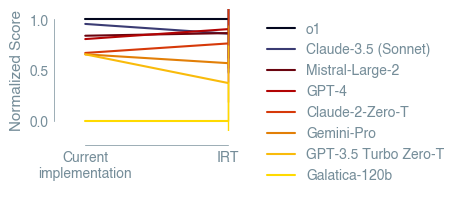

In [222]:
 #with open('all_topic_traces.pkl', 'rb') as f:
            #topic_traces = pickle.load(f)

models_to_plot = ['o1', 'Claude-3.5 (Sonnet)', 'Mistral-Large-2', 'GPT-4', 'Claude-2-Zero-T', 'Gemini-Pro',
                 'GPT-3.5 Turbo Zero-T', 'Galatica-120b']

# Get the estimates first
estimates = get_parameter_estimates(topic_traces['Technical Chemistry'])
abilities_mean = estimates['abilities']['mean']
abilities_std = estimates['abilities']['std']

print(abilities_mean)
print(abilities_std)

# plot model comparison with error bars
plot_model_comparison2(model_score_df, abilities_mean, abilities_std, models_to_plot)

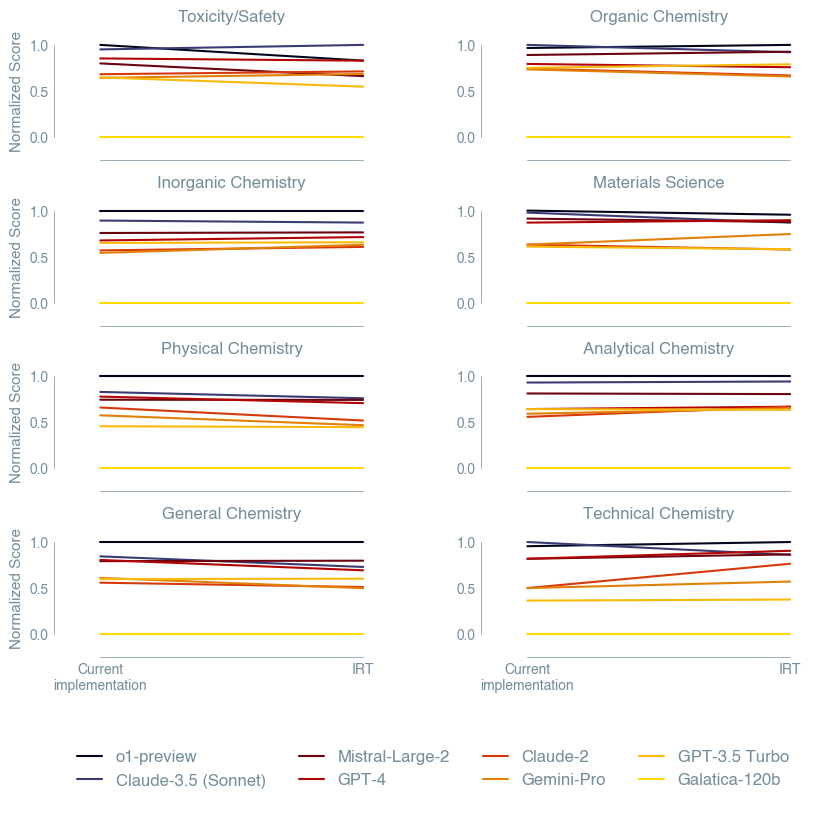

In [256]:
def plot_model_comparison_by_topic(df, topic_traces, topics, models_to_plot=None, colors=None):
    # Create figure with subplots using 2 columns
    n_topics = len(topics)
    n_cols = 2
    n_rows = ((n_topics)) // 2 + 1  
    
    fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=(3*ONE_COL_WIDTH_INCH, n_rows*ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
    if n_rows == 1:
        axes = np.array([axes])  # Ensure axes is always 2D
    axes = axes.reshape(n_rows, n_cols)
    
    if models_to_plot is None:
        models_to_plot = df.index
        
    if colors is None:
        colors = ['#03071E', '#3A3B73', '#6A040F', '#B20404', '#D63909', '#E27F07', '#F9BB0B', '#FFDA00']
    
    # Create dummy lines for legend (außerhalb der Schleife)
    legend_lines = []
    legend_labels = []
    for i, model in enumerate(models_to_plot):
        line = plt.Line2D([0], [0], color=colors[i % len(colors)], linewidth=1.5)
        legend_lines.append(line)
    
        if model == 'o1':
            legend_labels.append('o1-preview')
        elif model == 'Claude-2-Zero-T':
            legend_labels.append('Claude-2')
        elif model == 'GPT-3.5 Turbo Zero-T':
            legend_labels.append('GPT-3.5 Turbo')
        else:
            legend_labels.append(model)
    
    # Create subplot for each topic
    for topic_idx, topic in enumerate(topics):
        row = topic_idx // 2
        col = topic_idx % 2
        ax = axes[row, col]
        
        # Get topic-specific estimates
        estimates = get_parameter_estimates(topic_traces[topic])
        abilities_mean = estimates['abilities']['mean']
        abilities_std = estimates['abilities']['std']
        
        # Extract topic-specific data
        topic_scores = []
        for model in models_to_plot:
            topic_data = model_score_dicts['overall'][model]
            topic_mask = topic_data['topic'] == topic
            correct_answers = topic_data['all_correct_'][topic_mask]
            topic_score = correct_answers.mean()
            topic_scores.append(topic_score)
            
        topic_df = pd.DataFrame(topic_scores, index=models_to_plot, columns=['score'])
        
        # Normalize scores
        df_norm = (topic_df - topic_df.min()) / (topic_df.max() - topic_df.min())
        abilities_norm = (abilities_mean - abilities_mean.min()) / (abilities_mean.max() - abilities_mean.min())
        
        x = np.array([0.1, 0.9])
        y_values = []
        
        for i, model in enumerate(models_to_plot):
            idx = df.index.get_loc(model)
            y = np.array([df_norm.loc[model, 'score'], abilities_norm[idx]])
            y_values.extend([y[0], y[1]])
            
            # Plot lines
            ax.plot(x, y, '-', label=model, color=colors[i % len(colors)], linewidth=1.5)
        
        ax.set_xticks([0.1, 0.9])
        
        # Nur für die unterste Reihe X-Achsen-Labels anzeigen
        if row == (n_rows - 2):  # -2 weil die letzte Reihe für die Legende ist
            ax.set_xticklabels(['Current\nimplementation', 'IRT'], fontsize=10)
        else:
            ax.set_xticklabels([])
        
        if col == 0:
            ax.set_ylabel('Normalized Score', fontsize=11)
        
        # Set axis limits with padding
        ymin = min(y_values) - 0.05
        ymax = max(y_values) + 0.05
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(0, 1)
        
        # Set title with larger font size
        ax.set_title(topic, pad=10, fontsize=12)
        ax.set_facecolor('white')
        
        # Set tick label font sizes
        ax.tick_params(axis='both', which='major', labelsize=10)
        
        range_frame(ax, x, np.concatenate([df_norm.loc[models_to_plot, 'score'],
                                         abilities_norm[[df.index.get_loc(m) for m in models_to_plot]]]))
    
    # Create legend in the last row 
    for ax in axes[-1]:
        ax.axis('off')
    legend = fig.legend(legend_lines, legend_labels,
               loc='center',
               bbox_to_anchor=(0.5, 0.15),  
               ncol=len(models_to_plot) // 2,
               fontsize=12,
               frameon=False,
               handlelength=1.5)

    fig.patch.set_facecolor('white')

    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    plt.savefig("model_comparison_by_topic.pdf", format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Call the plotting function with all topics and topic_traces
plot_model_comparison_by_topic(
    df=model_score_df,
    topic_traces=topic_traces,
    topics=unique_topics,
    models_to_plot=models_to_plot
)

In [ ]:
# Define models to plot
models_to_plot = ['o1', 'Claude-3.5 (Sonnet)', 'Mistral-Large-2', 'GPT-4', 'Claude-2-Zero-T', 'Gemini-Pro',
                 'GPT-3.5 Turbo Zero-T', 'Galatica-120b']

# Get a list of all topics
sample_model = list(model_score_dicts['overall'].keys())[0]
unique_topics = model_score_dicts['overall'][sample_model]['topic'].unique()

# Get estimates for the first topic (needed for the function call)
initial_estimates = get_parameter_estimates(topic_traces[unique_topics[0]])
abilities_mean = initial_estimates['abilities']['mean']
abilities_std = initial_estimates['abilities']['std']

# Call the plotting function with all topics
plot_model_comparison_by_topic(
    df=model_score_df,
    abilities_mean=abilities_mean,
    abilities_std=abilities_std,
    topics=unique_topics,
    models_to_plot=models_to_plot
)

In [257]:
def plot_model_comparison_by_topic(df, topic_traces, topics, models_to_plot=None, colors=None):
    # Create figure with subplots using 2 columns
    n_topics = len(topics)
    n_cols = 2
    n_rows = ((n_topics)) // 2 + 1  # +1 für die Legende
    
    fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=(3*ONE_COL_WIDTH_INCH, n_rows*ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
    if n_rows == 1:
        axes = np.array([axes])  # Ensure axes is always 2D
    axes = axes.reshape(n_rows, n_cols)
    
    if models_to_plot is None:
        models_to_plot = df.index
        
    if colors is None:
        colors = ['#03071E', '#3A3B73', '#6A040F', '#B20404', '#D63909', '#E27F07', '#F9BB0B', '#FFDA00']
    
    # Create dummy lines for legend
    legend_lines = []
    legend_labels = []
    for i, model in enumerate(models_to_plot):
        line = plt.Line2D([0], [0], color=colors[i % len(colors)], linewidth=1.5)
        legend_lines.append(line)
        legend_labels.append(model)
    
    # Create subplot for each topic
    for topic_idx, topic in enumerate(topics):
        row = topic_idx // 2
        col = topic_idx % 2
        ax = axes[row, col]
        
        # Get topic-specific estimates
        estimates = get_parameter_estimates(topic_traces[topic])
        abilities_mean = estimates['abilities']['mean']
        abilities_std = estimates['abilities']['std']
        
        # Extract topic-specific data
        topic_scores = []
        for model in models_to_plot:
            topic_data = model_score_dicts['overall'][model]
            topic_mask = topic_data['topic'] == topic
            correct_answers = topic_data['all_correct_'][topic_mask]
            topic_score = correct_answers.mean()
            topic_scores.append(topic_score)
            
        topic_df = pd.DataFrame(topic_scores, index=models_to_plot, columns=['score'])
        
        # Normalize scores
        df_norm = (topic_df - topic_df.min()) / (topic_df.max() - topic_df.min())
        abilities_norm = (abilities_mean - abilities_mean.min()) / (abilities_mean.max() - abilities_mean.min())
        
        # Normalize standard deviations
        scale_factor = 1 / (abilities_mean.max() - abilities_mean.min())
        abilities_std_norm = abilities_std * scale_factor
        
        x = np.array([0.1, 0.9])
        y_values = []
        
        for i, model in enumerate(models_to_plot):
            idx = df.index.get_loc(model)
            y = np.array([df_norm.loc[model, 'score'], abilities_norm[idx]])
            y_values.extend([y[0], y[1]])
            
            # Plot lines
            ax.plot(x, y, '-', label=model, color=colors[i % len(colors)], linewidth=1.5)
            
            # Add error bars
            y_err = abilities_std_norm[idx]
            y_values.extend([abilities_norm[idx] - y_err, abilities_norm[idx] + y_err])
            ax.errorbar(0.9, abilities_norm[idx], yerr=y_err,
                       fmt='none', color=colors[i % len(colors)], capsize=0,
                       linewidth=1)
        
        ax.set_xticks([0.1, 0.9])
        
        # Nur für die unterste Reihe X-Achsen-Labels anzeigen
        if row == (n_rows - 2):  # -2 weil die letzte Reihe für die Legende ist
            ax.set_xticklabels(['Current\nimplementation', 'IRT'], fontsize=10)
        else:
            ax.set_xticklabels([])
        
        if col == 0:
            ax.set_ylabel('Normalized Score', fontsize=11)
        
        # Set axis limits with padding
        ymin = min(y_values) - 0.05
        ymax = max(y_values) + 0.05
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(0, 1)
        
        # Set title with larger font size
        ax.set_title(topic, pad=10, fontsize=12)
        ax.set_facecolor('white')
        
        # Set tick label font sizes
        ax.tick_params(axis='both', which='major', labelsize=10)
        
        range_frame(ax, x, np.concatenate([df_norm.loc[models_to_plot, 'score'],
                                         abilities_norm[[df.index.get_loc(m) for m in models_to_plot]]]))
        
        # Create dummy lines for legend (außerhalb der Schleife)
        legend_lines = []
        legend_labels = []
        for i, model in enumerate(models_to_plot):
            line = plt.Line2D([0], [0], color=colors[i % len(colors)], linewidth=1.5)
            legend_lines.append(line)
    
            if model == 'o1':
                legend_labels.append('o1-preview')
            elif model == 'Claude-2-Zero-T':
                legend_labels.append('Claude-2')
            elif model == 'GPT-3.5 Turbo Zero-T':
                legend_labels.append('GPT-3.5 Turbo')
            else:
                legend_labels.append(model)
        
        # Create legend in the last row
        for ax in axes[-1]:
            ax.axis('off')
        legend = fig.legend(legend_lines, legend_labels,
                   loc='center',
                   bbox_to_anchor=(0.5, 0.15),  
                   ncol=len(models_to_plot) // 2,
                   fontsize=12,
                   frameon=False,
                   handlelength=1.5)

        fig.patch.set_facecolor('white')

        # Adjust spacing between subplots
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    plt.savefig("model_comparison_by_topic_with_errors.pdf", format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

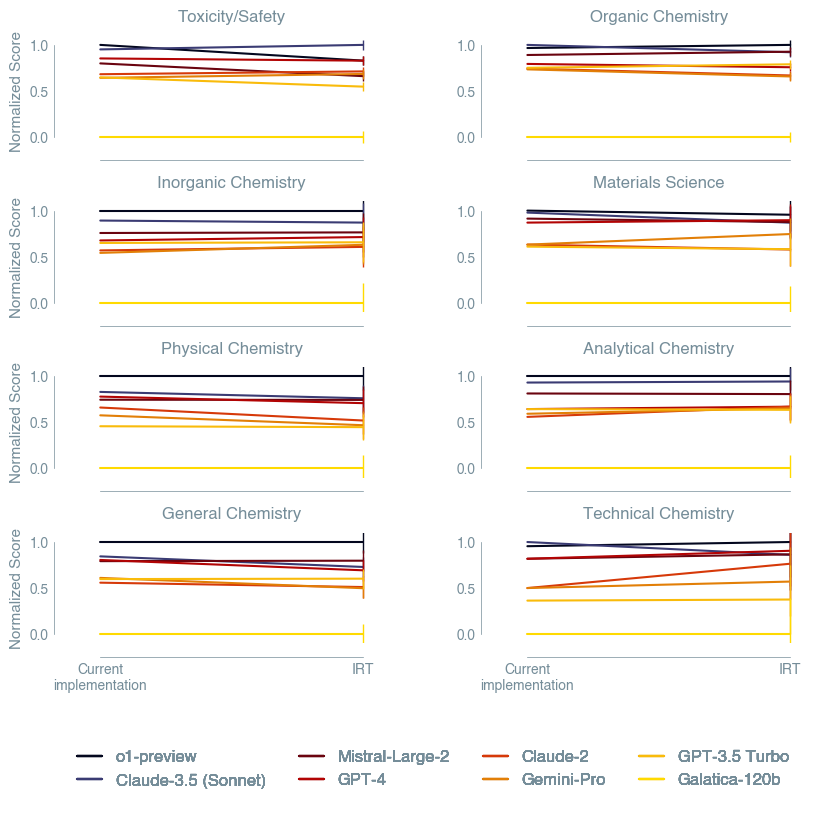

In [258]:

# Define models to plot
models_to_plot = ['o1', 'Claude-3.5 (Sonnet)', 'Mistral-Large-2', 'GPT-4', 'Claude-2-Zero-T', 'Gemini-Pro',
                 'GPT-3.5 Turbo Zero-T', 'Galatica-120b']

# Get a list of all topics
sample_model = list(model_score_dicts['overall'].keys())[0]
unique_topics = model_score_dicts['overall'][sample_model]['topic'].unique()

# Call the plotting function with all topics and topic_traces
plot_model_comparison_by_topic(
    df=model_score_df,
    topic_traces=topic_traces,
    topics=unique_topics,
    models_to_plot=models_to_plot
)

In [230]:
with open('all_topic_traces.pkl', 'wb') as f:
            pickle.dump(topic_traces, f)